In [146]:
import os
os.environ["PANDAS_ARROW_BACKEND"] = "pyarrow"

In [2]:
# Inserting libraries to work
import pandas as pd
import numpy as np
from pathlib import Path
import os
import re
import time
import comtradeapicall
import glob
import traceback
import pyarrow
import fastparquet

In [15]:
# Load the dataframe
db_23 = pd.read_csv('/Volumes/Toshi 1Tb/Trade/Trade Correo/tradeInGoods_baci_2023.csv', sep=";", encoding='latin1')
db_23["year"] = "2023"

db_23.head()
print(db_23["flow"].value_counts())

flow
I    11031704
E    11031704
Name: count, dtype: int64

In [30]:
# Dropping unnecesary columns for speed. Dictionary is in excel
db_23_clean = db_23.drop(columns=['country_desciption', 'partner_desciption', 'item_description'])

# Changing european , for .
db_23_clean["value"] = (db_23_clean["value"].astype(str).str.replace(",", ".", regex=False))
db_23_clean["value"] = pd.to_numeric(db_23_clean["value"], errors="coerce")

# Creating new variable that is the first two digits of the item code
db_23_clean["item2"] = db_23_clean["item_code"].astype(str).str[:2]

In [31]:
#Splitting database into exporter/importer
db_23_imp = db_23_clean[db_23_clean["flow"] == "I"].copy()
db_23_exp = db_23_clean[db_23_clean["flow"] == "E"].copy()

In [ ]:
# Group at the 2 digit level
grouped_exp = (db_23_exp.groupby(["year", "country_code", "partner_code", "item2"], as_index=False)["value"].sum())
grouped_imp = (db_23_imp.groupby(["year", "country_code", "partner_code", "item2"], as_index=False)["value"].sum())

In [ ]:
# Base Code before loop to test and replicate in for-loop

# Load the dataframe
db_23 = pd.read_csv('/Volumes/Toshi 1Tb/Trade/Trade Correo/tradeInGoods_baci_2023.csv', sep=";", encoding='latin1')
db_23["year"] = "2023"

# Dropping unnecesary columns for speed. Dictionary is in excel
db_23_clean = db_23.drop(columns=['country_desciption', 'partner_desciption', 'item_description'])

# Changing european , for .
db_23_clean["value"] = (db_23_clean["value"].astype(str).str.replace(",", ".", regex=False))
db_23_clean["value"] = pd.to_numeric(db_23_clean["value"], errors="coerce")

# Creating new variable that is the first two digits of the item code
db_23_clean["item2"] = db_23_clean["item_code"].astype(str).str[:2]

#Splitting database into exporter/importer
db_23_imp = db_23_clean[db_23_clean["flow"] == "I"].copy()
db_23_exp = db_23_clean[db_23_clean["flow"] == "E"].copy()

# Group at the 2 digit level
grouped_exp = (db_23_exp.groupby(["year", "country_code", "partner_code", "item2"], as_index=False)["value"].sum())
grouped_imp = (db_23_imp.groupby(["year", "country_code", "partner_code", "item2"], as_index=False)["value"].sum())

,year,country_code,partner_code,item2,value
0,2023,ABW,AGO,61,5081.0
1,2023,ABW,AGO,84,1519.0
2,2023,ABW,ARE,10,408.0
3,2023,ABW,ARE,22,160.0
4,2023,ABW,ARE,30,6969.0


In [3]:
# Folder containing all the CSV files
data_path = Path('/Volumes/Toshi 1Tb/Trade/Trade Correo/')

# Years you want to process
years = range(1996, 2023)

key_cols = ["country_code", "partner_code", "item2"]

all_exports = None
all_imports = None

for year in years:
    print(f"Processing {year}...")

    # ========== 1. Load CSV ==========
    file_path = data_path / f"tradeInGoods_baci_{year}.csv"
    db = pd.read_csv(file_path, sep=";", encoding='latin1', dtype = str, on_bad_lines="skip")
    # Added on_bad_lines skip because of a line on dataset 2009, that crashed the loop becuase it had 12 instead of 11 columns

    # ========== 2. Drop unnecessary columns ==========
    db_clean = db.drop(columns=[
        'country_desciption',
        'partner_desciption',
        'item_description',
        'date'
    ])

    # ========== 3. Fix decimal commas ==========
    db_clean["value"] = (db_clean["value"].astype(str).str.replace(",", ".", regex=False))
    db_clean["item_code"] = (db_clean["item_code"].astype(str).str.replace(",", ".", regex=False))
    db_clean["net_weight"] = (db_clean["net_weight"].astype(str).str.replace(",", ".", regex=False))

    db_clean["value"] = pd.to_numeric(db_clean["value"], errors="coerce")
    db_clean["item_code"] = pd.to_numeric(db_clean["item_code"], errors="coerce")
    db_clean["net_weight"] = pd.to_numeric(db_clean["net_weight"], errors="coerce")

    # ========== 4. Extract first two digits of item code ==========
    db_clean["item2"] = db_clean["item_code"].astype(str).str[:2]

    # ========== 5. Split into importer / exporter ==========
    db_imp = db_clean[db_clean["flow"] == "I"].copy()
    db_exp = db_clean[db_clean["flow"] == "E"].copy()

    # ========== 6. Group at 2-digit item level ==========
    grouped_exp = (db_exp.groupby(key_cols, as_index=False)["value"].sum())

    grouped_imp = (db_imp.groupby(key_cols, as_index=False)["value"].sum())

    # Store results in lists
    year_col = str(year)
    grouped_exp = grouped_exp.rename(columns={"value": year_col})
    grouped_imp = grouped_imp.rename(columns={"value": year_col})

    # 8. Full outer join with accumulated panel (one column per year)

    # Exports
    if exports_panel is None:
        exports_panel = grouped_exp
    else:
        exports_panel = exports_panel.merge(grouped_exp, on=key_cols, how="outer")

    # Imports
    if imports_panel is None:
        imports_panel = grouped_imp
    else:
        imports_panel = imports_panel.merge(grouped_imp, on=key_cols, how="outer")

# 9. (Optional) save the final wide panels
exports_panel.to_csv(data_path / "exports_CEPII_twodig.csv", index=False)
imports_panel.to_csv(data_path / "imports_CEPII_twodig.csv", index=False)

print("Done!")

Processing 1996...


KeyboardInterrupt: 

### Comtrade data for HS2 code comparison between CEPII and Comtrade

Primero creamos una funcion que ya incluye el API de comtrade para poder hacer los calls. Asimismo, simplificamos para que solo se cambien 4 elementos importantes:
- Pais origen
- Pais destino
- Año
- Exportacion / Importacion

In [ ]:
# Put your key in an env var (recommended)
subscription_key = "3052290edec74a228fdf50950851da90"

def get_comtrade_hs2_official(
    subscription_key: str,
    year: int,
    reporter_code: str,
    partner_code: str | None = None,   # None = all partners
    flow_code: str = "X",              
    cl_code: str = "HS",
    breakdown_mode: str = "classic",
    max_records: int = 90000
):
    df = comtradeapicall.getFinalData(
        subscription_key,
        typeCode="C",                  # goods/commodities
        freqCode="A",                  # annual
        clCode=cl_code,                # HS
        period=str(year),              # e.g., "2021"
        reporterCode=str(reporter_code),
        cmdCode="AG2",                 # all HS2 groups
        flowCode=flow_code,            # "X" exports or "M" imports (verify via reference table)
        partnerCode=partner_code,
        partner2Code=None,
        customsCode=None,
        motCode=None,
        maxRecords=max_records,
        format_output="JSON",
        aggregateBy=None,
        breakdownMode=breakdown_mode,  # "classic" = trade by partner/product
        countOnly=None,
        includeDesc=True
    )
    return df

In [43]:
df_hs2 = get_comtrade_hs2_official(
    subscription_key=subscription_key,
    year=2021,
    reporter_code="251",   # France (Comtrade code)
    partner_code=None,     # all partners
    flow_code="X"          
)

In [60]:
# De todas las variables que se obtienen de la API call solo dejamps las siguientes variables 
df_hs2_boni = df_hs2[["flowCode", "reporterCode", "reporterISO", "partnerCode", "partnerISO", "cmdCode", "cmdDesc", "qtyUnitAbbr", "qty", "fobvalue"]]

df_hs2_boni.head()

['typeCode', 'freqCode', 'refPeriodId', 'refYear', 'refMonth', 'period', 'reporterCode', 'reporterISO', 'reporterDesc', 'flowCode', 'flowDesc', 'partnerCode', 'partnerISO', 'partnerDesc', 'partner2Code', 'partner2ISO', 'partner2Desc', 'classificationCode', 'classificationSearchCode', 'isOriginalClassification', 'cmdCode', 'cmdDesc', 'aggrLevel', 'isLeaf', 'customsCode', 'customsDesc', 'mosCode', 'motCode', 'motDesc', 'qtyUnitCode', 'qtyUnitAbbr', 'qty', 'isQtyEstimated', 'altQtyUnitCode', 'altQtyUnitAbbr', 'altQty', 'isAltQtyEstimated', 'netWgt', 'isNetWgtEstimated', 'grossWgt', 'isGrossWgtEstimated', 'cifvalue', 'fobvalue', 'primaryValue', 'legacyEstimationFlag', 'isReported', 'isAggregate']


,flowCode,reporterCode,reporterISO,partnerCode,partnerISO,cmdCode,cmdDesc,qtyUnitAbbr,qty,fobvalue
0,X,251,FRA,499,MNE,21,Miscellaneous edible preparations,N/A,0.0,172497.943
1,X,251,FRA,262,DJI,21,Miscellaneous edible preparations,N/A,0.0,4382543.686
2,X,251,FRA,234,FRO,21,Miscellaneous edible preparations,N/A,0.0,1657.019
3,X,251,FRA,60,BMU,21,Miscellaneous edible preparations,N/A,0.0,3998.845
4,X,251,FRA,214,DOM,21,Miscellaneous edible preparations,N/A,0.0,1115777.102


# Loop to extract countries and their partners

Countries that will be used for this test
Argentina ,Brazil ,El Salvador ,France ,Germany ,Honduras ,Italy ,Japan 
,Mexico ,New Zealand ,Nigeria ,Philippines ,Russian Federation ,Saudi Arabia, 
Spain ,Suriname ,Türkiye ,USA ,Zimbabwe, China, Canada, United Kingdom, Singapore

["ARG","BRA","SLV","FRA","DEU",
 "HND","ITA","JPN","MEX","NZL",
 "NGA","PHL","RUS","SAU","ESP",
 "SUR","TUR","USA","ZWE","CHN",
 "CAN","GBR","SGP"]

In [69]:
# --- inputs  ---
years = [2003, 2009, 2017, 2021]          # List of years
reporter_codes = ["32" ,"76" ,"222" ,"251" ,"276" ,
                  "340" ,"380" ,"392" ,"484" ,"554", 
                  "566" ,"608" ,"643" ,"682" ,"724",
                  "740" ,"792" ,"842" ,"716", "156", "124", "826",
                  "702"]     # countries 
flow_codes = ["X", "M"]             # exports and 
partner_code = None                 # all partners
out_dir = "comtrade_data"        # folder to save CSVs
sleep_s = 5.0                       # small pause for rate limits

os.makedirs(out_dir, exist_ok=True)

keep_cols = ["flowCode", "reporterCode", "reporterISO", "partnerCode", "partnerISO","cmdCode", "cmdDesc", "qtyUnitAbbr", "qty", "fobvalue"]

# Function to make sure all files save fine
def safe_filename(s: str) -> str:
    """Make a filesystem-safe token."""
    s = str(s)
    s = s.strip()
    s = re.sub(r"[^\w\-\.]+", "_", s)   
    return s

for year in years:
    for reporter_code in reporter_codes:
        for flow_code in flow_codes:
            try:
                df_hs2 = get_comtrade_hs2_official(
                    subscription_key=subscription_key,
                    year=year,
                    reporter_code=str(reporter_code),
                    partner_code=partner_code,
                    flow_code=str(flow_code),
                )

                # If the API returns None or empty, skip
                if df_hs2 is None or df_hs2.empty:
                    print(f"⚠ Empty result: reporter={reporter_code}, flow={flow_code}, year={year}")
                    continue

                # Keep only requested variables (only those that exist to avoid KeyError)
                cols_present = [c for c in keep_cols if c in df_hs2.columns]
                df_hs2_boni = df_hs2[cols_present].copy()

                # Build filename from actual returned values (more reliable than inputs)
                rep_iso = df_hs2_boni["reporterISO"].iloc[0] if "reporterISO" in df_hs2_boni.columns else reporter_code
                flw = df_hs2_boni["flowCode"].iloc[0] if "flowCode" in df_hs2_boni.columns else flow_code

                fname = f"{safe_filename(rep_iso)}_{safe_filename(flw)}_{year}.csv"
                fpath = os.path.join(out_dir, fname)

                df_hs2_boni.to_csv(fpath, index=False)
                print(f"✓ Saved {fpath}  ({df_hs2_boni.shape[0]} rows, {df_hs2_boni.shape[1]} cols)")

                time.sleep(sleep_s)

            except Exception as e:
                print(f"✗ Failed: reporter={reporter_code}, flow={flow_code}, year={year} → {e}")

✓ Saved comtrade_data/CHN_X_2003.csv  (13333 rows, 10 cols)
✓ Saved comtrade_data/CHN_M_2003.csv  (6132 rows, 10 cols)
✓ Saved comtrade_data/CAN_X_2003.csv  (9376 rows, 10 cols)
✓ Saved comtrade_data/CAN_M_2003.csv  (9681 rows, 10 cols)
✓ Saved comtrade_data/GBR_X_2003.csv  (13457 rows, 10 cols)
✓ Saved comtrade_data/GBR_M_2003.csv  (8515 rows, 10 cols)
✓ Saved comtrade_data/SGP_X_2003.csv  (7463 rows, 10 cols)
✓ Saved comtrade_data/SGP_M_2003.csv  (5577 rows, 10 cols)
✓ Saved comtrade_data/CHN_X_2009.csv  (15275 rows, 10 cols)
✓ Saved comtrade_data/CHN_M_2009.csv  (7503 rows, 10 cols)
✓ Saved comtrade_data/CAN_X_2009.csv  (10971 rows, 10 cols)
✓ Saved comtrade_data/CAN_M_2009.csv  (10468 rows, 10 cols)
✓ Saved comtrade_data/GBR_X_2009.csv  (13407 rows, 10 cols)
✓ Saved comtrade_data/GBR_M_2009.csv  (8634 rows, 10 cols)
✓ Saved comtrade_data/SGP_X_2009.csv  (7744 rows, 10 cols)
✓ Saved comtrade_data/SGP_M_2009.csv  (6284 rows, 10 cols)
✓ Saved comtrade_data/CHN_X_2017.csv  (16456 rows,

# Joining Databases and running comparison 

In [40]:
# Joinning the Comtrade databases

comtrade_dir = "comtrade_data"   
files = sorted(glob.glob(os.path.join(comtrade_dir, "*.csv")))
print("Comtrade files found:", len(files))

# We keep the column names from the comtrade API formating
keep_cols = ["flowCode", "reporterCode", "reporterISO", "partnerCode", "partnerISO", "cmdCode", "cmdDesc", "qtyUnitAbbr", "qty", "fobvalue"]

def parse_year_from_filename(path):
    # expects: reporterISO_flowCode_year.csv  (e.g., FRA_X_2021.csv)
    base = os.path.basename(path).replace(".csv", "")
    year = int(base.split("_")[-1])
    return year

dfs = []
for fp in files:
    df = pd.read_csv(fp)

    # ensure year exists (from file name)
    if "year" not in df.columns:
        df["year"] = parse_year_from_filename(fp)

    # keep only the desired columns + year (create missing columns as NA)
    for c in keep_cols:
        if c not in df.columns:
            df[c] = pd.NA

    df = df[keep_cols + ["year"]]
    dfs.append(df)

comtrade_db = pd.concat(dfs, ignore_index=True)

print("Final combined Comtrade DB shape:", comtrade_db.shape)
comtrade_db.head()

# Renaming for better cleaner to CEPII
comtrade_db.rename(columns={"cmdCode": "item2", "reporterISO": "country_code", "partnerISO": "partner_code"}, inplace=True)

# Keeping only relevant columns
comtrade_db_clean = comtrade_db[["flowCode", "country_code", "partner_code", "item2", "year", "fobvalue"]]

# Separate exports and imports to compare with CEPII
comtrade_db_X = comtrade_db_clean[comtrade_db_clean["flowCode"] == "X"]
comtrade_db_M = comtrade_db_clean[comtrade_db_clean["flowCode"] == "M"]

Comtrade files found: 184
Final combined Comtrade DB shape: (1347882, 11)


In [103]:
comtrade_db_X.head()

,flowCode,country_code,partner_code,item2,year,fobvalue
17388,X,ARG,W00,39,2003,695887484.0
17389,X,ARG,DZA,39,2003,1319387.0
17390,X,ARG,AGO,39,2003,5092.0
17391,X,ARG,AUS,39,2003,919677.0
17392,X,ARG,AUT,39,2003,1797.0


In [38]:
# Insert the CEPII database
CEPII_X = pd.read_csv('/Volumes/Toshi 1Tb/Trade/exports_CEPII_twodig.csv')
CEPII_M = pd.read_csv('/Volumes/Toshi 1Tb/Trade/imports_CEPII_twodig.csv')

# Countries that we'll compare
iso3_list = [
    "ARG","BRA","SLV","FRA","DEU",
    "HND","ITA","JPN","MEX","NZL",
    "NGA","PHL","RUS","SAU","ESP",
    "SUR","TUR","USA","ZWE","CHN",
    "CAN","GBR","SGP"
]

# We filter to only leave the relevant countries
CEPII_X_filt = CEPII_X[CEPII_X["country_code"].isin(iso3_list)].copy()
CEPII_M_filt = CEPII_M[CEPII_M["country_code"].isin(iso3_list)].copy()

years = [2003, 2009, 2017, 2021]
year_cols = [str(y) for y in years]
# adjust keys to match your CEPII structure
key_cols = ["country_code", "partner_code", "item2"]

# Reduce CEPII databases to only relevant columns and years
CEPII_X_sub = CEPII_X_filt[key_cols + year_cols]
CEPII_M_sub = CEPII_M_filt[key_cols + year_cols]

CEPII_X_long = CEPII_X_sub.melt(
    id_vars=key_cols,
    value_vars=year_cols,
    var_name="year",
    value_name="cepii_value"
)

CEPII_M_long = CEPII_M_sub.melt(
    id_vars=key_cols,
    value_vars=year_cols,
    var_name="year",
    value_name="cepii_value"
)

# make year numeric + value numeric
CEPII_X_long["year"] = CEPII_X_long["year"].astype(int)
CEPII_M_long["year"] = CEPII_M_long["year"].astype(int)

CEPII_X_long["cepii_value"] = pd.to_numeric(CEPII_X_long["cepii_value"], errors="coerce")
CEPII_M_long["cepii_value"] = pd.to_numeric(CEPII_M_long["cepii_value"], errors="coerce")

print(CEPII_X_long.head())
print(CEPII_M_long.head())

  country_code partner_code item2  year  cepii_value
0          ARG          ABW    10  2003          NaN
1          ARG          ABW    12  2003          NaN
2          ARG          ABW    15  2003          NaN
3          ARG          ABW    16  2003      46905.0
4          ARG          ABW    17  2003          NaN
  country_code partner_code item2  year  cepii_value
0          ARG          ABW    22  2003          NaN
1          ARG          ABW    25  2003          NaN
2          ARG          ABW    27  2003   13817092.0
3          ARG          ABW    30  2003          NaN
4          ARG          ABW    39  2003          NaN


In [55]:
#Prepare comtrade databases for the join

for df in [comtrade_db_X, comtrade_db_M, CEPII_X_long, CEPII_M_long]:
    df["country_code"] = df["country_code"].astype(str).str.strip().str.upper()
    df["partner_code"] = df["partner_code"].astype(str).str.strip().str.upper()
    df["item2"] = df["item2"].astype(str).str.zfill(2)
    df["year"] = df["year"].astype(int)

comtrade_X_agg = (
    comtrade_db_X
    .groupby(["country_code", "partner_code", "item2", "year"], as_index=False)
    .agg(comtrade_value=("fobvalue", "sum"))
)

comtrade_M_agg = (
    comtrade_db_M
    .groupby(["country_code", "partner_code", "item2", "year"], as_index=False)
    .agg(comtrade_value=("fobvalue", "sum"))
)

CEPII_X_joined = CEPII_X_long.merge(
    comtrade_X_agg,
    on=["country_code", "partner_code", "item2", "year"],
    how="left"
)

CEPII_M_joined = CEPII_M_long.merge(
    comtrade_M_agg,
    on=["country_code", "partner_code", "item2", "year"],
    how="left"
)

/var/folders/p7/4fn3fxvn3wd9lw6y_ppgwd_h0000gn/T/ipykernel_54462/3706525963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["country_code"] = df["country_code"].astype(str).str.strip().str.upper()
/var/folders/p7/4fn3fxvn3wd9lw6y_ppgwd_h0000gn/T/ipykernel_54462/3706525963.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["partner_code"] = df["partner_code"].astype(str).str.strip().str.upper()
/var/folders/p7/4fn3fxvn3wd9lw6y_ppgwd_h0000gn/T/ipykernel_54462/3706525963.py:6: SettingWithCopyWarning

In [56]:
print("Exports — rows:", CEPII_X_joined.shape)
print("Imports — rows:", CEPII_M_joined.shape)

print("Share missing Comtrade (X):",
      CEPII_X_joined["comtrade_value"].isna().mean())

print("Share missing Comtrade (M):",
      CEPII_M_joined["comtrade_value"].isna().mean())

Exports — rows: (1298600, 6)
Imports — rows: (1138008, 6)
Share missing Comtrade (X): 0.49499075927922376
Share missing Comtrade (M): 0.5414162290599012


In [63]:
# First, compare how many rows have one or the other missing
only_cepii_X_nan = (
    CEPII_X_joined["cepii_value"].isna() &
    CEPII_X_joined["comtrade_value"].notna()
).sum()

only_comtrade_X_nan = (
    CEPII_X_joined["cepii_value"].notna() &
    CEPII_X_joined["comtrade_value"].isna()
).sum()

# Exports: Comtrade has a lot of missing values compared to CEPII
print("Exports")
print(" NaN in CEPII:", only_cepii_X_nan, "| NaN in Comtrade:", only_comtrade_X_nan)

only_cepii_M_nan = (
    CEPII_M_joined["cepii_value"].isna() &
    CEPII_M_joined["comtrade_value"].notna()
).sum()

only_comtrade_M_nan = (
    CEPII_M_joined["cepii_value"].notna() &
    CEPII_M_joined["comtrade_value"].isna()
).sum()

# Imports: Comtrade has a lot of missing values compared to CEPII
print("Imports")
print(" NaN in CEPII:", only_cepii_M_nan, "| NaN in Comtrade:", only_comtrade_M_nan)

# --------------------------------------

# Now the comparisons
df_X_cmp = CEPII_X_joined[
    CEPII_X_joined["cepii_value"].notna() &
    CEPII_X_joined["comtrade_value"].notna()
].copy()

df_M_cmp = CEPII_M_joined[
    CEPII_M_joined["cepii_value"].notna() &
    CEPII_M_joined["comtrade_value"].notna()
].copy()

Exports
 NaN in CEPII: 1466 | NaN in Comtrade: 178286
Imports
 NaN in CEPII: 2292 | NaN in Comtrade: 99287


In [58]:
# function to prepare comparison dataframe
def prepare_comparison(df, value_left="cepii_value", value_right="comtrade_value"):
    """
    Keep rows where both values exist and compute comparison metrics.
    """
    df_cmp = df[
        df[value_left].notna() &
        df[value_right].notna()
    ].copy()

    df_cmp["diff"] = df_cmp[value_right] - df_cmp[value_left]
    df_cmp["ratio"] = df_cmp[value_right] / df_cmp[value_left]

    df_cmp["log_cepii"] = np.log(df_cmp[value_left])
    df_cmp["log_comtrade"] = np.log(df_cmp[value_right])
    df_cmp["log_ratio"] = df_cmp["log_comtrade"] - df_cmp["log_cepii"]

    return df_cmp

df_X_cmp = prepare_comparison(CEPII_X_joined)
df_M_cmp = prepare_comparison(CEPII_M_joined)

print("Exports — rows with both values:", df_X_cmp.shape[0])
print("Imports — rows with both values:", df_M_cmp.shape[0])

print("EXPORTS")
print(df_X_cmp[["ratio", "log_ratio", "diff"]].describe(
    percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]
))

print("\nIMPORTS")
print(df_M_cmp[["ratio", "log_ratio", "diff"]].describe(
    percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]
))

Exports — rows with both values: 654339
Imports — rows with both values: 519580
EXPORTS
               ratio     log_ratio          diff
count  654339.000000  6.543390e+05  6.543390e+05
mean        4.002266          -inf -3.675306e+06
std       902.859640           NaN  1.822925e+08
min         0.000000          -inf -4.531747e+10
1%          0.003117 -5.770739e+00 -1.158352e+08
5%          0.060457 -2.805818e+00 -1.331453e+07
10%         0.185977 -1.682132e+00 -3.805906e+06
25%         0.560454 -5.790087e-01 -3.586800e+05
50%         0.934272 -6.798796e-02 -6.544000e+03
75%         1.000016  1.594172e-05  4.080000e-01
90%         1.317877  2.760218e-01  5.369413e+05
95%         1.861965  6.216324e-01  3.646597e+06
99%         5.773100  1.753209e+00  5.781591e+07
max    545965.500000  1.321031e+01  1.913076e+10

IMPORTS
              ratio     log_ratio          diff
count  5.195800e+05  5.195800e+05  5.195800e+05
mean   3.571721e+00          -inf -5.529225e+07
std    1.528498e+03     

/Users/david/Documents/BID/Trade/Trade_Bid/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/david/Documents/BID/Trade/Trade_Bid/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/david/Documents/BID/Trade/Trade_Bid/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/david/Documents/BID/Trade/Trade_Bid/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/david/Documents/BID/Trade/Trade_Bid/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtra

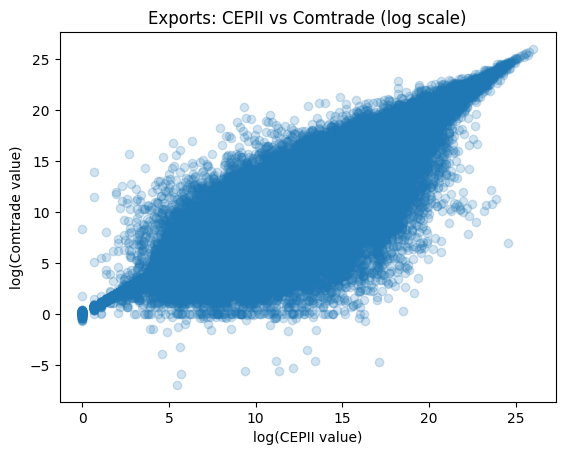

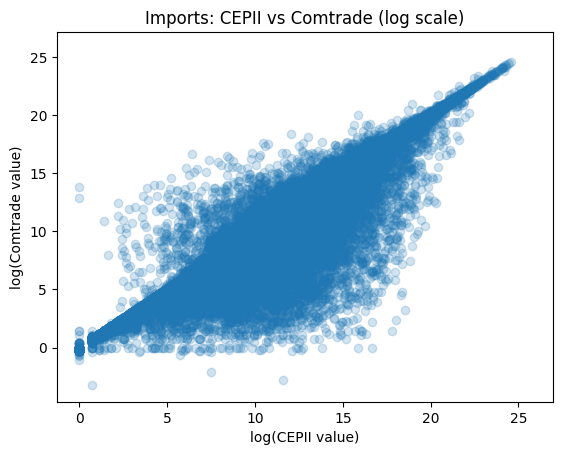

In [59]:
import matplotlib.pyplot as plt

def plot_log_scatter(df, title):
    plt.figure()
    plt.scatter(df["log_cepii"], df["log_comtrade"], alpha=0.2)
    mn = min(df["log_cepii"].min(), df["log_comtrade"].min())
    mx = max(df["log_cepii"].max(), df["log_comtrade"].max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("log(CEPII value)")
    plt.ylabel("log(Comtrade value)")
    plt.title(title)
    plt.show()

plot_log_scatter(df_X_cmp, "Exports: CEPII vs Comtrade (log scale)")
plot_log_scatter(df_M_cmp, "Imports: CEPII vs Comtrade (log scale)")


In [44]:
df_X_cmp.head()
df_M_cmp.head()

,country_code,partner_code,item2,year,cepii_value,comtrade_value
2,ARG,ABW,27,2003,13817092.0,0.0
23,ARG,AFG,39,2003,5019.0,0.0
24,ARG,AFG,40,2003,3725.0,0.0
25,ARG,AFG,48,2003,1.0,0.0
33,ARG,AFG,73,2003,4352.0,0.0


In [68]:
# Ensure numeric
df = CEPII_X_joined.copy()
df["cepii_value"] = pd.to_numeric(df["cepii_value"], errors="coerce")
df["comtrade_value"] = pd.to_numeric(df["comtrade_value"], errors="coerce")

# Aggregate by 2-digit code
sector_cmp = (
    df.groupby("item2", as_index=False)
      .agg(
          cepii_total=("cepii_value", "sum"),
          comtrade_total=("comtrade_value", "sum"),
          n_obs=("cepii_value", "size")
      )
)

# Gaps
sector_cmp["abs_gap"] = sector_cmp["cepii_total"] - sector_cmp["comtrade_total"]
sector_cmp["rel_gap"] = sector_cmp["abs_gap"] / sector_cmp["cepii_total"]

# Sort by largest absolute gap
sector_cmp = sector_cmp.sort_values("rel_gap", ascending=False)

sector_cmp.head(10)

,item2,cepii_total,comtrade_total,n_obs,abs_gap,rel_gap
87,na,3.875866e+10,0.000000e+00,12992,3.875866e+10,1.000000
69,80,1.555408e+11,5.265958e+09,15424,1.502749e+11,0.966144
40,50,2.122986e+10,6.325648e+09,11736,1.490422e+10,0.702040
10,20,3.491078e+11,1.171511e+11,16460,2.319567e+11,0.664427
70,81,7.235774e+10,3.801605e+10,14148,3.434169e+10,0.474610
60,70,2.526669e+11,1.538492e+11,17224,9.881763e+10,0.391099
30,40,4.908822e+11,3.193100e+11,17904,1.715722e+11,0.349518
4,14,1.694062e+09,1.165461e+09,9396,5.286012e+08,0.312032
17,27,3.233178e+12,2.360484e+12,15816,8.726943e+11,0.269918
0,10,2.712201e+11,2.051531e+11,15040,6.606701e+10,0.243592


In [69]:
df_nonzero = df[
    (df["comtrade_value"].notna()) &
    (df["comtrade_value"] > 0)
].copy()

sector_cmp_nonzero = (
    df_nonzero.groupby("item2", as_index=False)
      .agg(
          cepii_total=("cepii_value", "sum"),
          comtrade_total=("comtrade_value", "sum"),
          n_obs=("cepii_value", "size")
      )
)

sector_cmp_nonzero["abs_gap"] = (
    sector_cmp_nonzero["cepii_total"] -
    sector_cmp_nonzero["comtrade_total"]
)

sector_cmp_nonzero = sector_cmp_nonzero.sort_values("abs_gap", ascending=False)

sector_cmp_nonzero.head(10)

,item2,cepii_total,comtrade_total,n_obs,abs_gap
17,27,2.763060e+12,2.360484e+12,8580,4.025762e+11
74,85,5.054259e+12,4.659079e+12,13147,3.951807e+11
10,20,3.397966e+11,1.171511e+11,8250,2.226455e+11
73,84,4.986366e+12,4.768650e+12,13531,2.177162e+11
20,30,1.169197e+12,9.575967e+11,10293,2.116004e+11
30,40,4.813221e+11,3.193100e+11,11027,1.620121e+11
79,90,1.315303e+12,1.171202e+12,12042,1.441011e+11
69,80,1.320751e+11,5.265958e+09,3379,1.268091e+11
76,87,3.296997e+12,3.201873e+12,11528,9.512404e+10
60,70,2.481881e+11,1.538492e+11,9862,9.433887e+10


In [70]:
sector_zeros = (
    df.groupby("item2")
      .agg(
          n_obs=("comtrade_value", "size"),
          n_positive=("comtrade_value", lambda x: (x > 0).sum()),
          n_zero=("comtrade_value", lambda x: (x == 0).sum()),
          n_nan=("comtrade_value", lambda x: x.isna().sum())
      )
      .reset_index()
)

# Shares
sector_zeros["share_zero"] = sector_zeros["n_zero"] / sector_zeros["n_obs"]
sector_zeros["share_nan"] = sector_zeros["n_nan"] / sector_zeros["n_obs"]
sector_zeros["share_positive"] = sector_zeros["n_positive"] / sector_zeros["n_obs"]

# Sort by zero share
sector_zeros = sector_zeros.sort_values("share_zero", ascending=False)

sector_zeros.head(10)

,item2,n_obs,n_positive,n_zero,n_nan,share_zero,share_nan,share_positive
14,24,13756,5346,8,8402,0.000582,0.610788,0.388630
32,42,16768,9193,4,7571,0.000239,0.451515,0.548247
54,64,16576,8635,3,7938,0.000181,0.478885,0.520934
42,52,14220,6580,2,7638,0.000141,0.537131,0.462729
34,44,16908,9499,2,7407,0.000118,0.438077,0.561805
74,85,18832,13147,2,5683,0.000106,0.301774,0.698120
21,31,12140,5526,1,6613,0.000082,0.544728,0.455189
48,58,14092,6628,1,7463,0.000071,0.529591,0.470338
15,25,14980,7813,1,7166,0.000067,0.478371,0.521562
55,65,15648,7424,1,8223,0.000064,0.525498,0.474438


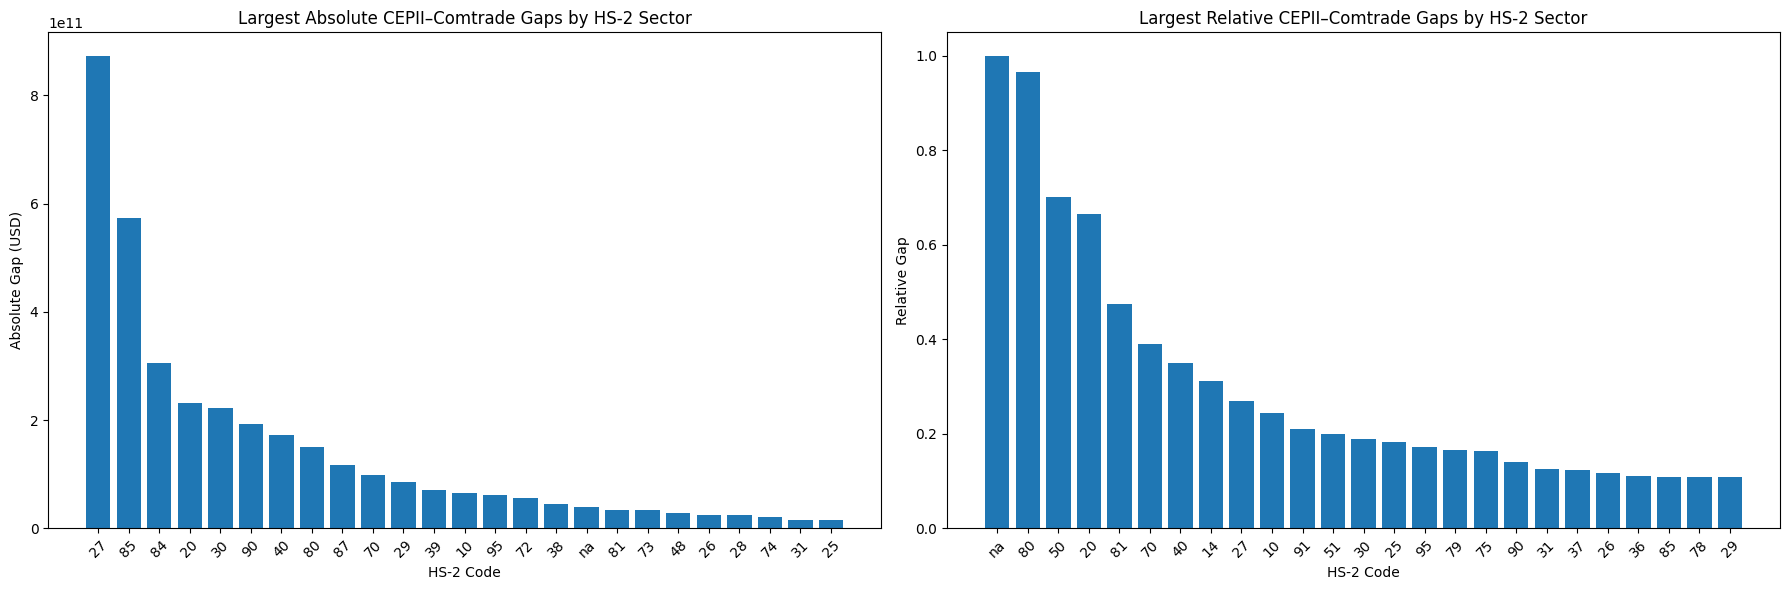

In [88]:
top_abs = (sector_cmp.sort_values("abs_gap", ascending=False).head(25))

top_rel = (sector_cmp.sort_values("rel_gap", ascending=False).head(25))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# --- Absolute gap (own ordering) ---
axes[0].bar(
    top_abs["item2"].astype(str),
    top_abs["abs_gap"]
)
axes[0].set_title("Largest Absolute CEPII–Comtrade Gaps by HS-2 Sector")
axes[0].set_xlabel("HS-2 Code")
axes[0].set_ylabel("Absolute Gap (USD)")
axes[0].tick_params(axis="x", rotation=45)

# --- Relative gap (own ordering) ---
axes[1].bar(
    top_rel["item2"].astype(str),
    top_rel["rel_gap"]
)
axes[1].set_title("Largest Relative CEPII–Comtrade Gaps by HS-2 Sector")
axes[1].set_xlabel("HS-2 Code")
axes[1].set_ylabel("Relative Gap")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [100]:
# Top 20 by absolute gap (with rank)
top_abs = (
    sector_cmp
    .sort_values("abs_gap", ascending=False)
    .head(15)
    .loc[:, ["item2", "abs_gap", "rel_gap"]]
    .reset_index(drop=True)
)
top_abs["rank_abs"] = top_abs.index + 1

# Top 20 by relative gap (with rank)
top_rel = (
    sector_cmp
    .sort_values("rel_gap", ascending=False)
    .head(15)
    .loc[:, ["item2", "rel_gap", "abs_gap"]]
    .reset_index(drop=True)
)
top_rel["rank_rel"] = top_rel.index + 1

# Rename columns so the combined table is readable
top_abs_ = top_abs.rename(columns={
    "item2": "HS2_abs",
    "abs_gap": "abs_gap",
    "rel_gap": "rel_gap_in_abs_rank"
})

top_rel_ = top_rel.rename(columns={
    "item2": "HS2_rel",
    "rel_gap": "rel_gap",
    "abs_gap": "abs_gap_in_rel_rank"
})


# Side-by-side table
side_by_side = pd.concat([top_abs_, top_rel_], axis=1)

# Display / print
side_by_side

,HS2_abs,abs_gap,rel_gap_in_abs_rank,rank_abs,HS2_rel,rel_gap,abs_gap_in_rel_rank,rank_rel
0,27,8.726943e+11,0.269918,1,na,1.000000,3.875866e+10,1
1,85,5.725036e+11,0.109432,2,80,0.966144,1.502749e+11,2
2,84,3.046723e+11,0.060054,3,50,0.702040,1.490422e+10,3
3,20,2.319567e+11,0.664427,4,20,0.664427,2.319567e+11,4
4,30,2.230227e+11,0.188903,5,81,0.474610,3.434169e+10,5
5,90,1.924095e+11,0.141103,6,70,0.391099,9.881763e+10,6
6,40,1.715722e+11,0.349518,7,40,0.349518,1.715722e+11,7
7,80,1.502749e+11,0.966144,8,14,0.312032,5.286012e+08,8
8,87,1.171431e+11,0.035295,9,27,0.269918,8.726943e+11,9
9,70,9.881763e+10,0.391099,10,10,0.243592,6.606701e+10,10


In [101]:
#Only show two that have both high absolute and relative gaps
matched = (
    top_abs.rename(columns={"item2": "item2_abs"})
    .merge(
        top_rel.rename(columns={"item2": "item2_rel"}),
        left_on="item2_abs",
        right_on="item2_rel",
        how="inner",
        suffixes=("_abs", "_rel")
    )
    .assign(item2=lambda d: d["item2_abs"])
    .loc[:, [
        "item2",
        "rank_abs", "abs_gap_abs", "rel_gap_abs",
        "rank_rel", "rel_gap_rel", "abs_gap_rel"
    ]]
    .sort_values(["rank_abs", "rank_rel"])
    .reset_index(drop=True)
)

matched

,item2,rank_abs,abs_gap_abs,rel_gap_abs,rank_rel,rel_gap_rel,abs_gap_rel
0,27,1,8.726943e+11,0.269918,9,0.269918,8.726943e+11
1,20,4,2.319567e+11,0.664427,4,0.664427,2.319567e+11
2,30,5,2.230227e+11,0.188903,13,0.188903,2.230227e+11
3,40,7,1.715722e+11,0.349518,7,0.349518,1.715722e+11
4,80,8,1.502749e+11,0.966144,2,0.966144,1.502749e+11
5,70,10,9.881763e+10,0.391099,6,0.391099,9.881763e+10
6,10,13,6.606701e+10,0.243592,10,0.243592,6.606701e+10
7,95,14,6.056736e+10,0.172497,15,0.172497,6.056736e+10


In [108]:
# --- Top 15 by absolute gap ---
list_abs15 = (
    top_abs
    .head(15)
    .assign(source="top15_abs")
)

# --- Top 15 by relative gap ---
list_rel15 = (
    top_rel
    .head(15)
    .assign(source="top15_rel")
)

# --- Matched list ---
list_matched = (
    matched
    .assign(source="matched")
    .loc[:, [
        "item2",
        "rank_abs", "abs_gap_abs", "rel_gap_abs",
        "rank_rel", "rel_gap_rel", "abs_gap_rel",
        "source"
    ]]
)

# --- Harmonize columns ---
list_abs15_clean = (
    list_abs15
    .rename(columns={
        "item2": "item2",
        "abs_gap": "abs_gap_abs",
        "rel_gap": "rel_gap_abs",
        "rank_abs": "rank_abs"
    })
    .assign(
        rank_rel=pd.NA,
        rel_gap_rel=pd.NA,
        abs_gap_rel=pd.NA
    )
)

list_rel15_clean = (
    list_rel15
    .rename(columns={
        "item2": "item2",
        "rel_gap": "rel_gap_rel",
        "abs_gap": "abs_gap_rel",
        "rank_rel": "rank_rel"
    })
    .assign(
        rank_abs=pd.NA,
        abs_gap_abs=pd.NA,
        rel_gap_abs=pd.NA
    )
)

# --- Stack all sources ---
combined = pd.concat(
    [list_abs15_clean, list_rel15_clean, list_matched],
    ignore_index=True
)

# --- Deduplicate with priority ---
priority = {"matched": 0, "top15_abs": 1, "top15_rel": 2}
combined["priority"] = combined["source"].map(priority)

final_list = (
    combined
    .sort_values("priority")
    .drop_duplicates(subset="item2", keep="first")
    .dropna(subset=["rank_abs", "rank_rel"], how="all")
    .drop(columns="priority")
    .reset_index(drop=True)
)

final_list = final_list[final_list["item2"] != "na"]
print(final_list)

relevant_two_digit_codes = final_list["item2"].tolist()
pd.Series(relevant_two_digit_codes, name="item2").to_csv("relevant_two_digit_codes.csv",index=False)
relevant_two_digit_codes

   item2   abs_gap_abs  rel_gap_abs rank_abs     source rank_rel  rel_gap_rel  \
0     95  6.056736e+10     0.172497       14    matched       15     0.172497   
1     70  9.881763e+10     0.391099       10    matched        6     0.391099   
2     80  1.502749e+11     0.966144        8    matched        2     0.966144   
3     40  1.715722e+11     0.349518        7    matched        7     0.349518   
4     30  2.230227e+11     0.188903        5    matched       13     0.188903   
5     20  2.319567e+11     0.664427        4    matched        4     0.664427   
6     27  8.726943e+11     0.269918        1    matched        9     0.269918   
7     10  6.606701e+10     0.243592       13    matched       10     0.243592   
8     72  5.673684e+10     0.073344       15  top15_abs     <NA>          NaN   
9     29  8.599884e+10     0.107876       11  top15_abs     <NA>          NaN   
10    87  1.171431e+11     0.035295        9  top15_abs     <NA>          NaN   
11    85  5.725036e+11     0

/var/folders/p7/4fn3fxvn3wd9lw6y_ppgwd_h0000gn/T/ipykernel_54462/1351079467.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(


['95',
 '70',
 '80',
 '40',
 '30',
 '20',
 '27',
 '10',
 '72',
 '29',
 '87',
 '85',
 '84',
 '90',
 '39',
 '25',
 '91',
 '14',
 '81',
 '50',
 '51']

Here the variable *relevant_two_digit_codes* contains the relevant HS2 codes that we will explore later when calling on the HS4 codes

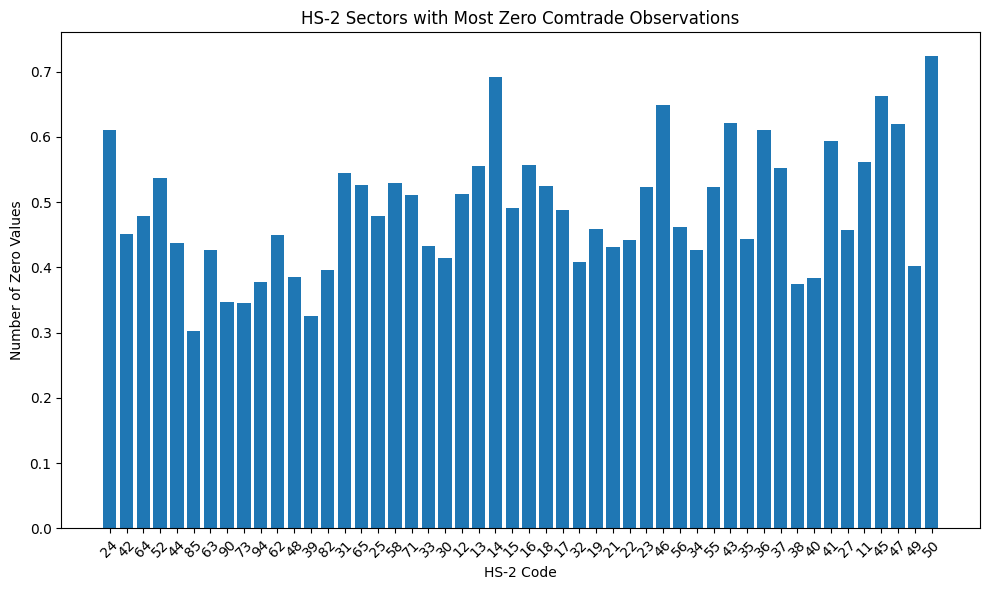

In [89]:
top_zero = sector_zeros.sort_values("n_zero", ascending=False).head(50)

plt.figure(figsize=(10, 6))
plt.bar(top_zero["item2"].astype(str), top_zero["share_nan"])
plt.title("HS-2 Sectors with Most Zero Comtrade Observations")
plt.xlabel("HS-2 Code")
plt.ylabel("Number of Zero Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

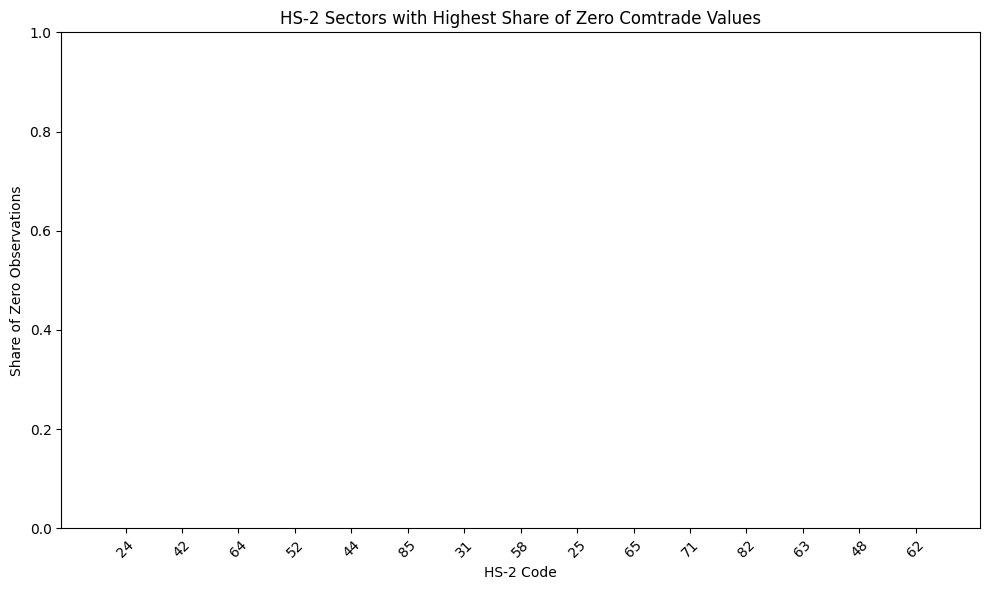

In [73]:
top_zero_share = sector_zeros.sort_values("share_zero", ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.bar(top_zero_share["item2"].astype(str), top_zero_share["share_zero"])
plt.title("HS-2 Sectors with Highest Share of Zero Comtrade Values")
plt.xlabel("HS-2 Code")
plt.ylabel("Share of Zero Observations")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Haciendo las comparaciones de Importaciones exportaciones, asegurando que X = M a HS6

In [3]:
# Los directorios con los que estaré trabajando
BASE_DIR = Path('/Volumes/Toshi 1Tb/Trade')
RAW_DIR = BASE_DIR / "Trade Correo"
CLEAN_DIR = BASE_DIR / "clean"
AGG_DIR = BASE_DIR / "aggregated"
MIRROR_DIR = BASE_DIR / "mirror_checks"

for d in [CLEAN_DIR, AGG_DIR, MIRROR_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [4]:
# Dado que estaré trabajando con bases enormes, es esencial solo dejar las variables esenciales
KEEP_COLS = [
    "country_code",
    "partner_code",
    "date",
    "item_code",
    "flow",
    "value"
]

# funcion para automatizar todo 
def clean_cepii_year(file_path):
    df = pd.read_csv(file_path,sep=";",encoding="latin1",low_memory=False)

    df = df[KEEP_COLS].copy()

    # año
    df["year"] = df["date"].astype(str).str[:4].astype(int)
    df.drop(columns="date", inplace=True)

    # valores a formato europeo
    df["value"] = (df["value"].astype(str).str.replace(".", "", regex=False).str.replace(",", ".", regex=False))
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    # para reducir la memoria
    for c in ["country_code", "partner_code", "item_code", "flow"]:
        df[c] = df[c].astype("category")

    return df

# Tolerancia de inconsistencia de 5%
def summarize_mirror(df, tol=0.05):
    both = df[df["_merge"] == "both"]
    return pd.DataFrame({
        "n_total": [len(df)],
        "n_both": [len(both)],
        "share_both": [len(both) / len(df)],
        "share_consistent": [(both["rel_diff"] <= tol).mean()]
    })

In [14]:
# las variables en las que se agrupara para hacer las comparaciones
GROUP_KEYS = ["year", "country_code", "partner_code", "item_code"]

def build_mirror(df):
    # Exports
    df_X = df[df["flow"] == "E"].copy()
    df_X = (
    df_X
    .groupby(GROUP_KEYS, as_index=False, observed=True)["value"]
    .sum()
    .rename(columns={"value": "export_value"}))

    # Imports (mirrored)
    df_I = df[df["flow"] == "I"].copy()
    df_I = df_I.rename(
        columns={
            "country_code": "partner_code",
            "partner_code": "country_code",
            "value": "import_value"
        }
    )
    
    df_I = (
    df_I
    .groupby(GROUP_KEYS, as_index=False, observed=True)["import_value"]
    .sum()
)

    # Merge
    df_mirror = df_X.merge(
        df_I,
        on=GROUP_KEYS,
        how="outer",
        indicator=True
    )

    # Differences
    df_mirror["abs_diff"] = (
        df_mirror["export_value"] - df_mirror["import_value"]
    ).abs()

    df_mirror["rel_diff"] = (
        df_mirror["abs_diff"] /
        df_mirror[["export_value", "import_value"]].mean(axis=1)
    )

    return df_mirror

def summarize_mirror_with_trim(df, tol=0.05, min_value=10_000):
    both = df[df["_merge"] == "both"]

    trimmed = both[
        (both["export_value"] >= min_value) &
        (both["import_value"] >= min_value)
    ]

    return pd.DataFrame({
        "n_total": [len(df)],
        "n_both": [len(both)],
        "n_trimmed": [len(trimmed)],
        "share_trimmed": [len(trimmed) / len(both)],
        "share_consistent": [(trimmed["rel_diff"] <= tol).mean()]
    })

# Variables para ver los diagnosticos de cambios y filtros

In [19]:
def trimming_diagnostics(df_mirror, min_value):
    """Counts: how many obs are retained after trimming (conditional on _merge=='both')."""
    both = df_mirror[df_mirror["_merge"] == "both"]

    kept = both[
        (both["export_value"] >= min_value) &
        (both["import_value"] >= min_value)
    ]

    return pd.DataFrame({
        "n_both": [len(both)],
        "n_kept": [len(kept)],
        "share_kept_obs": [len(kept) / len(both) if len(both) else None],
    })

def trimming_value_diagnostics(df_mirror, min_value):
    """Values: how much export value is retained after trimming (conditional on _merge=='both')."""
    both = df_mirror[df_mirror["_merge"] == "both"]

    total_val = both["export_value"].sum()
    kept = both[
        (both["export_value"] >= min_value) &
        (both["import_value"] >= min_value)
    ]
    kept_val = kept["export_value"].sum()

    return pd.DataFrame({
        "total_export_value": [total_val],
        "kept_export_value": [kept_val],
        "share_value_retained": [kept_val / total_val if total_val else None],
    })





### Testeo del código para hacer los matchings con una sola base antes del upscaling




In [6]:
def process_one_file(file_path, target_year=None):
    print(f"Processing {file_path.name}")

    df_clean = clean_cepii_year(file_path)

    if target_year is not None:
        df_clean = df_clean[df_clean["year"] == target_year]

        if df_clean.empty:
            print(f"Skipping {file_path.name} (no data for {target_year})")
            return

    year = df_clean["year"].iloc[0]

    # Save clean
    df_clean.to_parquet(
        CLEAN_DIR / f"cepii_clean_{year}.parquet",
        index=False
    )

    # Mirror
    df_mirror = build_mirror(df_clean)

    df_mirror.to_parquet(
        MIRROR_DIR / f"cepii_mirror_{year}.parquet",
        index=False
    )

    print(f"✓ Finished {year}")

process_one_file(RAW_DIR / "tradeInGoods_baci_1996.csv", target_year=1996)

Processing tradeInGoods_baci_1996.csv


/var/folders/p7/4fn3fxvn3wd9lw6y_ppgwd_h0000gn/T/ipykernel_54462/1831991980.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(GROUP_KEYS, as_index=False)["value"]
/var/folders/p7/4fn3fxvn3wd9lw6y_ppgwd_h0000gn/T/ipykernel_54462/1831991980.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(GROUP_KEYS, as_index=False)["import_value"]


✓ Finished 1996


In [7]:
MIRROR_DIR = Path('/Volumes/Toshi 1Tb/Trade/mirror_checks')

df_mirror_96 = pd.read_parquet(
    MIRROR_DIR / "cepii_mirror_1996.parquet",
    engine="pyarrow"
)

df_mirror_96.shape
df_mirror_96.head()
df_mirror_96.dtypes

df_mirror_96["_merge"].value_counts()
df_mirror_96.sort_values("rel_diff", ascending=False).head(10)

,year,country_code,partner_code,item_code,export_value,import_value,_merge,abs_diff,rel_diff
243167114,1996,ZWE,ZAF,9.405101e+10,0.0,13661.0,both,13661.0,2.0
81096649,1996,GBR,ANT,3.808101e+10,0.0,171438.0,both,171438.0,2.0
81096777,1996,GBR,ANT,8.540990e+10,0.0,22390.0,both,22390.0,2.0
81096771,1996,GBR,ANT,8.517401e+10,0.0,130672.0,both,130672.0,2.0
81096770,1996,GBR,ANT,8.517302e+10,0.0,21651.0,both,21651.0,2.0
81096769,1996,GBR,ANT,8.517100e+10,0.0,8312.0,both,8312.0,2.0
81096765,1996,GBR,ANT,8.508900e+10,0.0,4704.0,both,4704.0,2.0
81096758,1996,GBR,ANT,8.473304e+10,0.0,15316.0,both,15316.0,2.0
81096757,1996,GBR,ANT,8.471932e+10,0.0,21796.0,both,21796.0,2.0
81096754,1996,GBR,ANT,8.464909e+10,0.0,1249.0,both,1249.0,2.0


In [8]:
summary_96 = summarize_mirror(df_mirror_96, tol=0.05)
summary_96

,n_total,n_both,share_both,share_consistent
0,243177840,243177840,1.0,0.017381


In [9]:
df_both = df_mirror_96[df_mirror_96["_merge"] == "both"]

df_large = df_both[
    (df_both["export_value"] > 10_000) &
    (df_both["import_value"] > 10_000)
]

summarize_mirror(df_large, tol=0.05)

,n_total,n_both,share_both,share_consistent
0,2822331,2822331,1.0,1.0


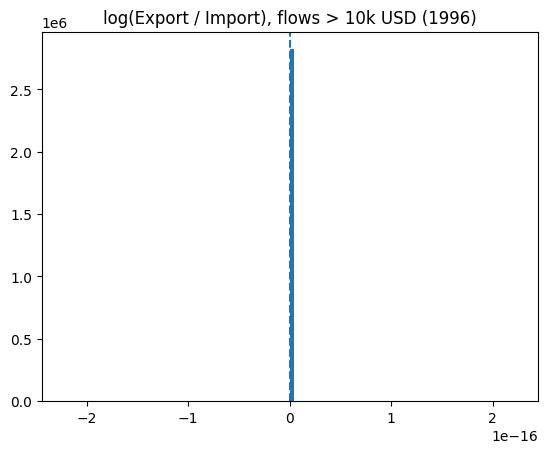

In [10]:
import numpy as np
import matplotlib.pyplot as plt

ratio = df_large["export_value"] / df_large["import_value"]
ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure()
plt.hist(np.log(ratio), bins=100)
plt.axvline(0, linestyle="--")
plt.title("log(Export / Import), flows > 10k USD (1996)")
plt.show()



### Fin del testeo, inicio del pipeline por año



In [20]:
# ---- USER SETTINGS ----
TOL = 0.05             # tolerance para consistent error match
MIN_VALUE = 10_000      # trimming threshold 
SAVE_CLEAN = True       
SAVE_MIRROR = True      
SAVE_TRIMMED = True     
ENGINE = "pyarrow"      

# ---- encontrar los documentos
files = sorted(
    f for f in RAW_DIR.glob("*.csv")
    if not f.name.startswith("._") and not f.name.startswith(".")
)

# ---- Container to build a yearly summary panel ----
all_summaries = []

for f in files:
    try:
        print(f"\nProcessing {f.name}")

        # 1) Clean raw file (your function: keeps only needed cols, fixes year, fixes EU value formatting, etc.)
        df_clean = clean_cepii_year(f)

        # Defensive: determine year from data (works even if file naming is inconsistent)
        year = int(df_clean["year"].iloc[0])

        # 2) Save cleaned yearly dataset (optional but useful for debugging / reproducibility)
        if SAVE_CLEAN:
            clean_path = CLEAN_DIR / f"cepii_clean_{year}.parquet"
            df_clean.to_parquet(clean_path, index=False, engine=ENGINE)

        # 3) Build mirror table: exports i->j matched to mirrored imports j<-i (your function)
        df_mirror = build_mirror(df_clean)

        # --------- Diadnostics before trimming ----------
        diag_counts = trimming_diagnostics(df_mirror, MIN_VALUE).assign(year=year, min_value=MIN_VALUE)
        diag_values = trimming_value_diagnostics(df_mirror, MIN_VALUE).assign(year=year, min_value=MIN_VALUE)

        # quick console signal (prevents “too fast = empty?” anxiety)
        print(
            f"    Kept obs: {int(diag_counts['n_kept'].iloc[0]):,} / {int(diag_counts['n_both'].iloc[0]):,} "
            f"({diag_counts['share_kept_obs'].iloc[0]:.3f}) | "
            f"Value retained: {diag_values['share_value_retained'].iloc[0]:.3%}"
        )

        all_summaries.append(diag_counts.assign(note="trim_diag_counts", tol=TOL))
        all_summaries.append(diag_values.assign(note="trim_diag_values", tol=TOL))

        for thr in [1_000, 5_000, 10_000, 25_000]:
            dc = trimming_diagnostics(df_mirror, thr).assign(
                year=year,
                min_value=thr,
                note="robust_counts",
                tol=TOL
            )
            dv = trimming_value_diagnostics(df_mirror, thr).assign(
                year=year,
                min_value=thr,
                note="robust_values",
                tol=TOL
            )
            all_summaries.append(dc)
            all_summaries.append(dv)
        # ------------------------------------------------

        # 4) guardar el mirror
        if SAVE_MIRROR:
            mirror_path = MIRROR_DIR / f"cepii_mirror_{year}.parquet"
            df_mirror.to_parquet(mirror_path, index=False, engine=ENGINE)

        print(
            f"  Year {year} | "
            f"rows={len(df_mirror):,} | "
            f"both={(df_mirror['_merge'] == 'both').sum():,} | "
            f"sum_X={df_mirror['export_value'].sum():,.0f} | "
            f"sum_M={df_mirror['import_value'].sum():,.0f}")

        # 5) Trimming: quitando los valores minimos de acuerdo a la literatura
        df_trimmed = df_mirror[
            (df_mirror["_merge"] == "both") &
            (df_mirror["export_value"] >= MIN_VALUE) &
            (df_mirror["import_value"] >= MIN_VALUE)
        ].copy()

        print(
            f"    Trimmed (>{MIN_VALUE:,.0f}$): "
            f"{len(df_trimmed):,} rows | "
            f"consistent={(df_trimmed['rel_diff'] <= TOL).mean():.3f}")

        if SAVE_TRIMMED:
            trimmed_path = MIRROR_DIR / f"cepii_mirror_{year}_trimmed_min{MIN_VALUE}.parquet"
            df_trimmed.to_parquet(trimmed_path, index=False, engine=ENGINE)

        # 6) Summaries
        #    A) Summary con todo el mirror
        summary_full = summarize_mirror(df_mirror, tol=TOL)
        summary_full["year"] = year
        summary_full["min_value"] = 0
        summary_full["tol"] = TOL
        summary_full["note"] = "full"

        #    B) summary 
        if len(df_trimmed) > 0:
            share_consistent_trim = (df_trimmed["rel_diff"] <= TOL).mean()
            mean_rel_diff_trim = df_trimmed["rel_diff"].mean()
            median_rel_diff_trim = df_trimmed["rel_diff"].median()
        else:
            share_consistent_trim = None
            mean_rel_diff_trim = None
            median_rel_diff_trim = None

        summary_trim = pd.DataFrame({
            "n_total": [len(df_mirror)],
            "n_both": [(df_mirror["_merge"] == "both").sum()],
            "n_trimmed": [len(df_trimmed)],
            "share_both": [((df_mirror["_merge"] == "both").mean())],
            "share_consistent": [share_consistent_trim],
            "mean_rel_diff": [mean_rel_diff_trim],
            "median_rel_diff": [median_rel_diff_trim],
        })
        summary_trim["year"] = year
        summary_trim["min_value"] = MIN_VALUE
        summary_trim["tol"] = TOL
        summary_trim["note"] = f"trimmed_min{MIN_VALUE}"

        # 7) añadimos los summaries al panel
        all_summaries.append(summary_full)
        all_summaries.append(summary_trim)

        # 8) 
        del df_clean, df_mirror, df_trimmed

        print(f"✓ Finished {year}")

    except Exception as e:
        print(f"✗ Failed on {f.name}: {e}")
        print(traceback.format_exc())
        continue

# 9) Save the full summary panel (one file with 2 rows per year: full + trimmed)
if all_summaries:
    df_summary_panel = pd.concat(all_summaries, ignore_index=True)

    # Save as CSV (easy to open) and parquet (fast)
    df_summary_panel.to_csv(MIRROR_DIR / f"mirror_summary_panel_tol{TOL}_min{MIN_VALUE}.csv", index=False)
    df_summary_panel.to_parquet(MIRROR_DIR / f"mirror_summary_panel_tol{TOL}_min{MIN_VALUE}.parquet", index=False, engine=ENGINE)

    print("\n✓ Saved summary panel:")
    print(df_summary_panel.sort_values(["year", "min_value"]).head())
else:
    print("\nNo summaries produced (all files failed or were skipped).")


Processing tradeInGoods_baci_1996.csv
    Kept obs: 2,824,063 / 4,226,791 (0.668) | Value retained: 99.896%
  Year 1996 | rows=4,412,751 | both=4,226,791 | sum_X=5,075,859,197,724 | sum_M=5,076,652,523,282
    Trimmed (>10,000$): 2,824,063 rows | consistent=1.000
✓ Finished 1996

Processing tradeInGoods_baci_1997.csv
    Kept obs: 3,254,266 / 5,095,517 (0.639) | Value retained: 99.879%
  Year 1997 | rows=5,292,833 | both=5,095,517 | sum_X=5,531,152,308,137 | sum_M=5,528,256,084,399
    Trimmed (>10,000$): 3,254,266 rows | consistent=1.000
✓ Finished 1997

Processing tradeInGoods_baci_1998.csv
    Kept obs: 3,377,694 / 5,375,988 (0.628) | Value retained: 99.868%
  Year 1998 | rows=5,568,360 | both=5,375,988 | sum_X=5,497,054,633,696 | sum_M=5,496,393,126,180
    Trimmed (>10,000$): 3,377,694 rows | consistent=1.000
✓ Finished 1998

Processing tradeInGoods_baci_1999.csv
    Kept obs: 3,498,323 / 5,704,492 (0.613) | Value retained: 99.862%
  Year 1999 | rows=5,904,030 | both=5,704,492 | 




#### Codigo para observar los flows the "otros"




In [25]:
hscodes = pd.read_excel("HSCodeandDescription.xlsx", sheet_name= "HS22")
hscodes["n_digits"] = hscodes["Code"].astype(str).str.len()
hscodes.head()

,Classification,Code,Description,Parent Code,Level,IsBasicLevel,n_digits
0,H6,01,Animals; live,TOTAL,2,0,2
1,H6,0101,"Horses, asses, mules and hinnies; live",01,4,0,4
2,H6,010121,"Horses; live, pure-bred breeding animals",0101,6,1,6
3,H6,010129,"Horses; live, other than pure-bred breeding an...",0101,6,1,6
4,H6,010130,Asses; live,0101,6,1,6


In [35]:
hs_other = hscodes[hscodes["Description"].str.contains("other", case=False, na=False)]
hs_other_2d = hs_other[hs_other["n_digits"] == 2]
hs_other_4d = hs_other[hs_other["n_digits"] == 4]
hs_other_6d = hs_other[hs_other["n_digits"] == 6]

#REsultados generales por desagregación
hs_other.head()
print("All strings containing other:", hs_other.shape[0])
print("2-digit:", hs_other_2d.shape[0])
print("4-digit:", hs_other_4d.shape[0])
print("6-digit:", hs_other_6d.shape[0])

#Patron particular de n.e.s.
pattern = r"not elsewhere specified"
hs_other_nes = hscodes[hscodes["Description"].str.contains(pattern, case=False, na=False, regex=True)].copy()
hs_other_2d_nes = hs_other_nes[hs_other_nes["n_digits"] == 2]
hs_other_4d_nes = hs_other_nes[hs_other_nes["n_digits"] == 4]
hs_other_6d_nes = hs_other_nes[hs_other_nes["n_digits"] == 6]

# Inspect results
print("All strings containing 'not elsewhere specified':", hs_other_nes.shape[0])
print("2-digit:", hs_other_2d_nes.shape[0])
print("4-digit:", hs_other_4d_nes.shape[0])
print("6-digit:", hs_other_6d_nes.shape[0])


All strings containing other: 1926
2-digit: 14
4-digit: 387
6-digit: 1525
All strings containing 'not elsewhere specified': 41
2-digit: 3
4-digit: 16
6-digit: 22


In [30]:
output_file = "HS_codes_with_other.xlsx"

with pd.ExcelWriter(output_file, engine=None) as writer:
    hs_other.to_excel(writer, sheet_name="all_other", index=False)
    hs_other_2d.to_excel(writer, sheet_name="HS2_other", index=False)
    hs_other_4d.to_excel(writer, sheet_name="HS4_other", index=False)
    hs_other_6d.to_excel(writer, sheet_name="HS6_other", index=False)

print(f"Excel file written: {output_file}")

Excel file written: HS_codes_with_other.xlsx


#### Codigo para extraer los codigos importantes de la base de Comtrade

In [67]:
import re
import pandas as pd
import comtradeapicall

reference_types = [
    "flow",
    "reporter",
    "partner",
    "qtyunit",
    "cmd:HS",
    "cmd:H6"
]

# Excel-illegal control chars: 0x00–0x1F excluding tab/newline/carriage return
_illegal = re.compile(r"[\x00-\x08\x0B\x0C\x0E-\x1F]")

def clean_for_excel(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    obj_cols = df.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        df[c] = df[c].astype(str).map(lambda s: _illegal.sub("", s) if isinstance(s, str) else s)
        # Optional: convert literal "nan"/"None" back to missing
        df.loc[df[c].isin(["nan", "None"]), c] = pd.NA
    return df

reference_tables = {}
failed_refs = {}

for ref in reference_types:
    try:
        df = comtradeapicall.getReference(ref)
        if df is not None and not df.empty:
            df = clean_for_excel(df)  # <-- key fix
            reference_tables[ref] = df
            print(f"✓ Loaded reference: {ref} ({df.shape[0]} rows)")
        else:
            failed_refs[ref] = "Empty DataFrame"
            print(f"⚠ Empty reference: {ref}")
    except Exception as e:
        failed_refs[ref] = str(e)
        print(f"✗ Failed reference: {ref} → {e}")

output_path = "comtrade_reference_tables.xlsx"

with pd.ExcelWriter(output_path, engine=None) as writer:
    for ref_name, df in reference_tables.items():
        sheet_name = ref_name.replace(":", "_")[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"\nSaved {len(reference_tables)} reference tables to {output_path}")

✓ Loaded reference: flow (10 rows)
✓ Loaded reference: reporter (255 rows)
✓ Loaded reference: partner (310 rows)
✓ Loaded reference: qtyunit (41 rows)
✓ Loaded reference: cmd:HS (8262 rows)
✓ Loaded reference: cmd:H6 (6940 rows)

Saved 6 reference tables to comtrade_reference_tables.xlsx
